In [1]:
%reload_ext autoreload
%autoreload 2

In [5]:
import torch
print(torch.__version__)
from rdkit import Chem
from rdkit.Chem.rdchem import BondType as BT
import torch.nn.functional as F
from torch_sparse import coalesce
from torch_geometric.data import Data
import os
import numpy as np
from torch_geometric.utils import to_dense_adj
from rdkit.Chem import Draw
import networkx as nx
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from collections import Counter
from networkx.drawing.nx_pydot import graphviz_layout


2.0.1


In [3]:
def mols_from_file(pathfile: str, drop_none: bool = False):
    '''
    takes as input a path/to/file.ext 
    where ext can be:
    .sdf, .csv, .txt, .smiles
    it returns all mols from file
    if drop_none: drops all mols non valid for rdkit
    '''
    filename_ext = os.path.splitext(pathfile)[-1].lower()
    if filename_ext in ['.sdf']:
        suppl = Chem.SDMolSupplier(pathfile)
    elif filename_ext in ['.csv', '.txt', '.smiles']:
        suppl = Chem.SmilesMolSupplier(pathfile, titleLine=False)
    else:
        raise TypeError(f"{filename_ext} not supported")
    if drop_none:
        return [x for x in suppl if x is not None]
    return [x for x in suppl]

In [4]:
# guacm_smiles = "/home/nobilm@usi.ch/master_thesis/guacamol/guacamol2_molgpt.smiles"
guacm_smiles = "/home/nobilm@usi.ch/master_thesis/guacamol/testdata.smiles"
guac_mols = mols_from_file(guacm_smiles, True)

[11:42:56] WARNING: no name column found on line 0
[11:42:56] WARNING: no name column found on line 1
[11:42:56] WARNING: no name column found on line 2
[11:42:56] WARNING: no name column found on line 3
[11:42:56] WARNING: no name column found on line 4
[11:42:56] WARNING: no name column found on line 5
[11:42:56] WARNING: no name column found on line 6
[11:42:56] WARNING: no name column found on line 7
[11:42:56] WARNING: no name column found on line 8
[11:42:56] WARNING: no name column found on line 9
[11:42:56] WARNING: no name column found on line 10
[11:42:56] WARNING: no name column found on line 11
[11:42:56] WARNING: no name column found on line 12
[11:42:56] WARNING: no name column found on line 13
[11:42:56] WARNING: no name column found on line 14
[11:42:56] WARNING: no name column found on line 15
[11:42:56] WARNING: no name column found on line 16
[11:42:56] WARNING: no name column found on line 17
[11:42:56] WARNING: no name column found on line 18
[11:42:56] WARNING: no

In [7]:
nAtoms = Counter()
for mol in guac_mols: nAtoms.update([mol.GetNumAtoms()])

plt.bar(list(nAtoms.keys()), nAtoms.values(), color='g')
plt.show()

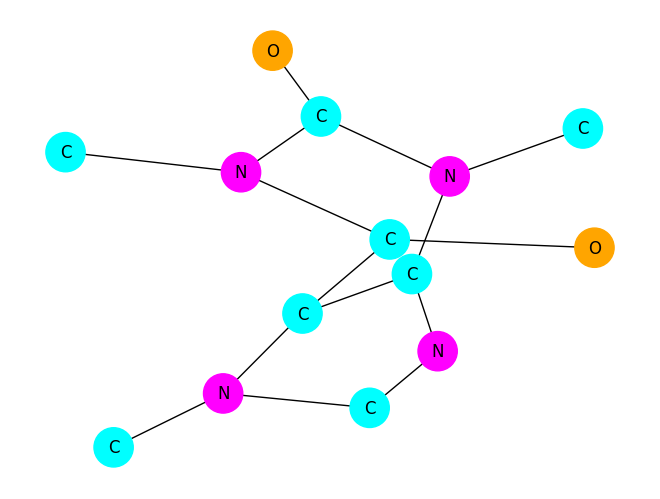

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [71]:
# import library --------------------------------------------------------------
from rdkit import Chem
import networkx as nx
import matplotlib.pyplot as plt

from networkx import from_numpy_array, to_numpy_array 

# define the smiles string and covert it into a molecule sturcture ------------
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
caffeine_mol = Chem.MolFromSmiles(caffeine_smiles)

# define the function for coverting rdkit object to networkx object -----------     
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
        
    return G

# conver rdkit object to networkx object --------------------------------------
caffeine_nx = mol_to_nx(caffeine_mol)

caffeine_atom = nx.get_node_attributes(caffeine_nx, 'atom_symbol')
caffeine_bonds = nx.get_edge_attributes(caffeine_nx, 'bond_type')

color_map = {'C': 'cyan',
             'O': 'orange',
             'N': 'magenta'}  

caffeine_colors = []
for idx in caffeine_nx.nodes():
    if (caffeine_nx.nodes[idx]['atom_symbol'] in color_map):
        caffeine_colors.append(color_map[caffeine_nx.nodes[idx]['atom_symbol']])
    else:
        caffeine_colors.append('gray')
    
nx.draw(caffeine_nx,
        labels=caffeine_atom,
        with_labels = True,
        node_color=caffeine_colors,
        node_size=800)

# nx.draw_networkx_edge_labels(caffeine_nx, caffeine_bonds)


plt.show()

# print out the adjacency matrix ---------------------------------------------- 
matrix = nx.to_numpy_array(caffeine_nx)
print(matrix)

In [53]:
# caffeine_bonds

{(0, 1): rdkit.Chem.rdchem.BondType.SINGLE,
 (1, 2): rdkit.Chem.rdchem.BondType.AROMATIC,
 (1, 5): rdkit.Chem.rdchem.BondType.AROMATIC,
 (2, 3): rdkit.Chem.rdchem.BondType.AROMATIC,
 (3, 4): rdkit.Chem.rdchem.BondType.AROMATIC,
 (4, 5): rdkit.Chem.rdchem.BondType.AROMATIC,
 (4, 11): rdkit.Chem.rdchem.BondType.AROMATIC,
 (5, 6): rdkit.Chem.rdchem.BondType.AROMATIC,
 (6, 7): rdkit.Chem.rdchem.BondType.DOUBLE,
 (6, 8): rdkit.Chem.rdchem.BondType.AROMATIC,
 (8, 9): rdkit.Chem.rdchem.BondType.AROMATIC,
 (8, 13): rdkit.Chem.rdchem.BondType.SINGLE,
 (9, 10): rdkit.Chem.rdchem.BondType.DOUBLE,
 (9, 11): rdkit.Chem.rdchem.BondType.AROMATIC,
 (11, 12): rdkit.Chem.rdchem.BondType.SINGLE}

In [48]:
node_idx_type_dict = nx.get_node_attributes(caffeine_nx, name='atom_symbol')
for node_idx, node_type in node_idx_type_dict.items():
    print(node_idx , node_type)

0 C
1 N
2 C
3 N
4 C
5 C
6 C
7 O
8 N
9 C
10 O
11 N
12 C
13 C


In [69]:
T = nx.algorithms.bfs_tree(caffeine_nx, 0)
T2 = nx.algorithms.bfs_tree(caffeine_nx, 2)


f = lambda g, i: max(nx.shortest_path_length(g, i), key=nx.shortest_path_length(g, i).get)

print("T depth", f(T, 0))
print("T2 depth", f(T2, 2))

# nx.draw(test,
#         # labels=caffeine_atom,
#         with_labels = True,
#         # node_color=caffeine_colors,
#         node_size=500)
# plt.show()

T depth 10
T2 depth 13


In [49]:
for nidx in nx.topological_sort(T):
    print(node_idx_type_dict[nidx])

C
N
C
C
N
C
C
N
O
N
C
C
C
O


In [73]:
# G = T2

# G_bonds = nx.get_edge_attributes(caffeine_nx, 'bond_type')
# prev_idx = None
# for nidx in nx.topological_sort(G):
#     print(node_idx_type_dict[nidx])
#     if prev_idx == None:
#         prev_idx = nidx
#         continue
#     print(G_bonds.get((prev_idx, nidx), ""))


In [74]:
# pos = graphviz_layout(T, prog="twopi")
# nx.draw(T,
#         pos,
#         with_labels = True)
# plt.show()

In [75]:
# pos = graphviz_layout(T2, prog="twopi")
# nx.draw(T2,
#         pos,
#         with_labels = True)
# plt.show()

In [70]:
def bfs_seq(G, start_id):
    '''
    Builds a bfs node sequence
    :param G:nx graph
    :param start_id: id of the staring node, it must be a carbon
    :return:
    '''
    dictionary = dict(nx.bfs_successors(G, start_id))
    start = [start_id]
    output = [start_id]
    while len(start) > 0:
        next = []
        while len(start) > 0:
            current = start.pop(0)
            neighbor = dictionary.get(current)
            if neighbor is not None:
                #### a wrong example, should not permute here!
                # shuffle(neighbor)
                next = next + neighbor
        output = output + next
        start = next
    return output

In [76]:
node_idx_type_dict = nx.get_node_attributes(caffeine_nx, name='atom_symbol')
for node_idx, node_type in node_idx_type_dict.items():
    print(node_idx , node_type)

0 C
1 N
2 C
3 N
4 C
5 C
6 C
7 O
8 N
9 C
10 O
11 N
12 C
13 C


[0, 1, 2, 5, 3, 4, 6, 11, 7, 8, 9, 12, 13, 10]

In [85]:
seq = bfs_seq(caffeine_nx, 0)
print(len(seq))
for idx in seq:
    print(caffeine_nx.nodes[idx]['atom_symbol'])

14
C
N
C
C
N
C
C
N
O
N
C
C
C
O


14
CCCNNNONCCCCCO

In [101]:
def get_permutations(G):
    bfs_orderings = []
    for i in G:
        if G.nodes[i]['atom_symbol'] == 'C': 
            seq = bfs_seq(G, i)        
            bfs_orderings.append("")
            for idx in seq:
                bfs_orderings[-1] +=G.nodes[idx]['atom_symbol']
    return bfs_orderings

In [102]:
# define the smiles string and covert it into a molecule sturcture ------------
benzene_smiles = 'c1ccccc1'
benzene_mol = Chem.MolFromSmiles(benzene_smiles)

# define the function for coverting rdkit object to networkx object -----------     
benzene_g =  mol_to_nx(benzene_mol)

In [104]:
set(get_permutations(benzene_g))

{'CCCCCC'}

In [ ]:
# Convert the graph into PyTorch geometric
pyg_graph = from_networkx(G)

# Their encoding

In [151]:
N = 10
def create_square_array(n):
    if n < 1: return None  # Handle invalid input    
    square_array = np.arange(1, n*n + 1).reshape(n, n)
    return square_array

asd1 = create_square_array(10)

In [152]:
asd = np.tril(asd1, k=-1) ; asd

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [11,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [21, 22,  0,  0,  0,  0,  0,  0,  0,  0],
       [31, 32, 33,  0,  0,  0,  0,  0,  0,  0],
       [41, 42, 43, 44,  0,  0,  0,  0,  0,  0],
       [51, 52, 53, 54, 55,  0,  0,  0,  0,  0],
       [61, 62, 63, 64, 65, 66,  0,  0,  0,  0],
       [71, 72, 73, 74, 75, 76, 77,  0,  0,  0],
       [81, 82, 83, 84, 85, 86, 87, 88,  0,  0],
       [91, 92, 93, 94, 95, 96, 97, 98, 99,  0]])

In [153]:
asd = asd[1:N, :N-1]
asd, asd.shape

(array([[11,  0,  0,  0,  0,  0,  0,  0,  0],
        [21, 22,  0,  0,  0,  0,  0,  0,  0],
        [31, 32, 33,  0,  0,  0,  0,  0,  0],
        [41, 42, 43, 44,  0,  0,  0,  0,  0],
        [51, 52, 53, 54, 55,  0,  0,  0,  0],
        [61, 62, 63, 64, 65, 66,  0,  0,  0],
        [71, 72, 73, 74, 75, 76, 77,  0,  0],
        [81, 82, 83, 84, 85, 86, 87, 88,  0],
        [91, 92, 93, 94, 95, 96, 97, 98, 99]]),
 (9, 9))

In [157]:
max_prev_node = 5
adj_output = np.zeros((asd.shape[0], max_prev_node))
for i in range(asd.shape[0]):
    input_start = max(0, i - max_prev_node + 1)
    input_end = i + 1
    output_start = max_prev_node + input_start - input_end
    output_end = max_prev_node
    print(i, input_start,input_end-1)
    adj_output[i, output_start:output_end] = asd[i, input_start:input_end]
    adj_output[i,:] = adj_output[i,:][::-1] 

0 0 0
1 0 1
2 0 2
3 0 3
4 0 4
5 1 5
6 2 6
7 3 7
8 4 8


In [159]:
adj_output, adj_output.shape

(array([[11.,  0.,  0.,  0.,  0.],
        [22., 21.,  0.,  0.,  0.],
        [33., 32., 31.,  0.,  0.],
        [44., 43., 42., 41.,  0.],
        [55., 54., 53., 52., 51.],
        [66., 65., 64., 63., 62.],
        [77., 76., 75., 74., 73.],
        [88., 87., 86., 85., 84.],
        [99., 98., 97., 96., 95.]]),
 (9, 5))

# my encoding

In [ ]:
def encode_adj(adj, original, max_prev_node, edge_feature_dims):
    '''
    :param adj: A of current g with edge features as els : (V, V, 4)
    :param original: plain A of current g (without edge features: a binary matrix)
    :param max_prev_node: number of nodes of current graph - 1
    :return: encoded structure for the edges
    '''
    n = original.shape[0]
    temp = np.zeros((n, max_prev_node, edge_feature_dims))

    original_tril = np.tril(original, k=-1)  # lower tri of original A
    original_tril_idx = np.nonzero(original_tril)

    # begin by setting all as absent
    for r in range(temp.shape[0]):
        for c in range(temp.shape[1]):
            temp[r, c, 0] = 1

    for index in range(len(original_tril_idx[0])):
        i = original_tril_idx[0][index]
        j = original_tril_idx[1][index]
        temp[i - 1, j, :] = np.concatenate((np.array([0.]), adj[i, j, :]), 0)
        # [i - 1, j ]  since we drop first row of A in the encoding, we need to 'move up' every row-idx

    adj_output = np.zeros((n, max_prev_node, edge_feature_dims))

    # flip
    for i in range(0, n):
        adj_output[i, :i + 1, :] = np.flip(temp[i, :i + 1, :], 0)

    return adj_output

In [156]:

temp = np.zeros((n, max_prev_node, 1))

original_tril = np.tril(asd1, k=-1)  # lower tri of original A
original_tril_idx = np.nonzero(original_tril)
temp.shape

(10, 5, 1)

In [137]:
original_tril

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [11,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [21, 22,  0,  0,  0,  0,  0,  0,  0,  0],
       [31, 32, 33,  0,  0,  0,  0,  0,  0,  0],
       [41, 42, 43, 44,  0,  0,  0,  0,  0,  0],
       [51, 52, 53, 54, 55,  0,  0,  0,  0,  0],
       [61, 62, 63, 64, 65, 66,  0,  0,  0,  0],
       [71, 72, 73, 74, 75, 76, 77,  0,  0,  0],
       [81, 82, 83, 84, 85, 86, 87, 88,  0,  0],
       [91, 92, 93, 94, 95, 96, 97, 98, 99,  0]])

In [136]:
original_tril_idx

(array([1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7,
        7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9,
        9]),
 array([0, 0, 1, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5, 0,
        1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
        8]))

In [ ]:
def decode_adj(adj_output):
    '''
        recover to adj from adj_output
        note: here adj_output have shape (n-1)*m
    '''
    max_prev_node = adj_output.shape[1]
    adj = np.zeros((adj_output.shape[0], adj_output.shape[0]))
    for i in range(adj_output.shape[0]):
        input_start = max(0, i - max_prev_node + 1)
        input_end = i + 1
        output_start = max_prev_node + max(0, i - max_prev_node + 1) - (i + 1)
        output_end = max_prev_node
        adj[i, input_start:input_end] = adj_output[i,::-1][output_start:output_end] # reverse order
    adj_full = np.zeros((adj_output.shape[0]+1, adj_output.shape[0]+1))
    n = adj_full.shape[0]
    adj_full[1:n, 0:n-1] = np.tril(adj, 0)
    adj_full = adj_full + adj_full.T

    return adj_full